## Introduction to SNAP

### Objective

This notebook introduces the SNAP - Sentinel Application Platform and creates a SNAP Graph to produce the Sigma0 of the staged-in Sentinel-1 product

### Overview

The Sentinel Application Platform - or SNAP - in short is a collection of executable tools and Application Programming Interfaces (APIs) which have been developed to facilitate the utilisation, viewing and processing of a variety of remotely sensed data. The functionality of SNAP is accessed through the Sentinel Toolbox. The purpose of the Sentinel Toolbox is not to duplicate existing commercial packages, but to complement them with functions dedicated to the handling of data products of earth observing satellites.

The main components of the Sentinel Toolbox are:

* An intuitive desktop application used for EO data visualisation, analysing and processing.
* A set of scientific data processors running either from the command-line or invoked by the desktop application.
* The command-line tool gpt (graph processing tool) is used to execute processing graphs made up of operators nodes developed using the SNAP GPF (see Java API below).
* A data product converter tool pconvert allowing a user to convert raw data products to the BEAM-DIMAP standard format, to GeoTIFF, to HDF-5 or to RGB images.
* A Java™ API which provides ready-to-use components for remote sensing related application development and plug-in points for new SNAP extension modules. Besides a number of extension points such as product reader and writers, the SNAP API comprises the Graph Processing Framework (GPF) which is used to rapidly create raster data processors. The Rich Client Platform is used to develop rich GUI user interface applications based on SNAP.

### Snappy 

SNAP also foresees using Python to call the SNAP API code and to extend SNAP by plugins written in Python.

In [22]:
import snappy

%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.getcwd())
from  ellip_snap_helpers import op_help, backscatter

from geopandas import GeoDataFrame
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get some information about the staged-in product using Snappy

In [2]:


s1_prd = GeoDataFrame(pd.read_pickle('s1_prd.pickle'))

s1_prd.iloc[0]['local_path']

'/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip'

In [3]:
reader = snappy.ProductIO.getProductReader("SENTINEL-1")
product = reader.readProductNodes(s1_prd.iloc[0]['local_path'], None)

In [4]:
width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
band_names = product.getBandNames()

In [5]:
print("Product: %s, %d x %d pixels" % (name, width, height))
print("Bands:   %s" % (list(band_names)))

Product: S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770, 10508 x 9992 pixels
Bands:   ['Amplitude_HH', 'Intensity_HH', 'Amplitude_HV', 'Intensity_HV']


#### Plot a subset of the data

In [6]:
x = 1727
y = 1438
width = 6186
height = 3942

HashMap = snappy.jpy.get_type('java.util.HashMap')    
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('region', "%s,%s,%s,%s" % (x, y, width, height))
subset = snappy.GPF.createProduct('Subset', parameters, product)

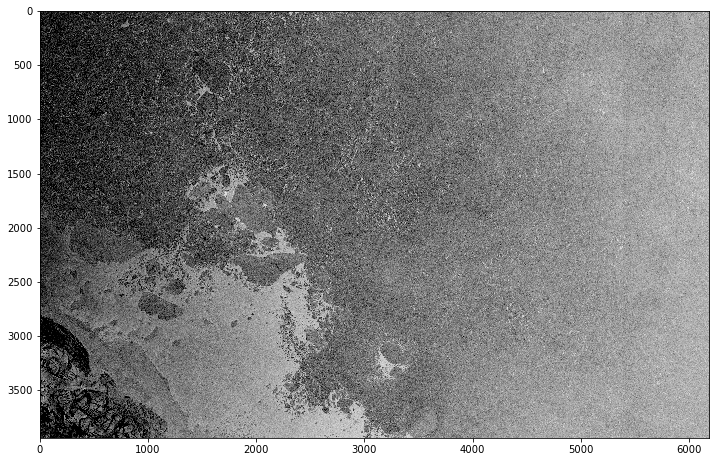

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    
    return imgplot 

plotBand(subset, 'Amplitude_HH', 0, 750)

### The SNAP Graph Processing Framework (GPF)

Within SNAP, the term data processor refers to a software module which creates an output product from one or more input products configured by a set of processing parameters. A product is basically a collection of bands which again provide numerical raster data for a spectral radiance, geophysical property or quality flag. 

As its name states, the GPF allows to construct directed, acyclic graphs (DAG) of processing nodes. A node in the graph refers to a GPF operator, which implements the algorithm to be executed. The node also has the role to configure the operation by specifying the operator's source nodes and providing values for the processing parameters. 

### The SNAP Operators

List all the Sentinel-1 toolbox SNAP Operators:

In [8]:
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

op_spi_it = snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpis().iterator()

while op_spi_it.hasNext():
    
    op_spi = op_spi_it.next()
    
    if 's1tbx' in op_spi.getOperatorDescriptor().getName():
        print(op_spi.getOperatorAlias(), op_spi.getOperatorDescriptor().getName())

('Stack-Split', 'org.esa.s1tbx.insar.gpf.StackSplitWriter')
('StampsExport', 'org.esa.s1tbx.insar.gpf.StampsExportOp')
('Principle-Components', 'org.esa.s1tbx.insar.gpf.PCAOp')
('BandMerge', 'org.esa.s1tbx.utilities.gpf.BandMergeOp')
('AdaptiveThresholding', 'org.esa.s1tbx.fex.gpf.oceantools.AdaptiveThresholdingOp')
('BandSelect', 'org.esa.s1tbx.utilities.gpf.BandSelectOp')
('Double-Difference-Interferogram', 'org.esa.s1tbx.sentinel1.gpf.DoubleDifferenceInterferogramOp')
('Change-Detection', 'org.esa.s1tbx.fex.gpf.ChangeDetectionOp')
('Cross-Correlation', 'org.esa.s1tbx.insar.gpf.coregistration.CrossCorrelationOp')
('IntegerInterferogram', 'org.esa.s1tbx.insar.gpf.IntegerInterferogramOp')
('TestPattern', 'org.esa.s1tbx.utilities.gpf.TestPatternOp')
('Update-Geo-Reference', 'org.esa.s1tbx.sar.gpf.geometric.UpdateGeoRefOp')
('Coherence', 'org.esa.s1tbx.insar.gpf.CoherenceOp')
('Oil-Spill-Clustering', 'org.esa.s1tbx.fex.gpf.oceantools.OilSpillClusteringOp')
('SARSim-Terrain-Correction', '

### Describe a SNAP Operator

SNAP Operators have several parameters, some with default values defined.



For instance, here's the **Apply-Orbit-File** SNAP Operator information 

In [10]:
op_help('CreateStack')

Operator name: org.esa.s1tbx.insar.gpf.coregistration.CreateStackOp
Operator alias: CreateStack

Parameters:

masterBandNames: The list of source bands.
Default Value: None

Possible values: []

slaveBandNames: The list of source bands.
Default Value: None

Possible values: []

resamplingType: The method to be used when resampling the slave grid onto the master grid.
Default Value: NONE

Possible values: []

extent: The output image extents.
Default Value: Master

Possible values: ['Master', 'Minimum', 'Maximum']

initialOffsetMethod: Method to be used in computation of initial offset between master and slave
Default Value: Orbit

Possible values: ['Orbit', 'Product Geolocation']



### Implement a Graph to generate Sigma0

**Goal**: produce the Sigma0 (sigma nought)

**Backscatter** 

Backscatter is the portion of the outgoing radar signal that the target redirects directly back towards the radar antenna. Backscattering is the process by which backscatter is formed. The scattering cross section in the direction toward the radar is called the backscattering cross section; the usual notation is the symbol sigma . It is a measure of the reflective strength of a radar target. The normalised measure of the radar return from a distributed target is called the backscatter coefficient, or sigma nought , and is defined as per unit area on the ground. If the signal formed by backscatter is undesired, it is called clutter. Other portions of the incident radar energy may be reflected and scattered away from the radar or absorbed.

**Workflow** 

The Graph will thus:

- Read the Sentinel-1 product
- Apply the SNAP operators ThermalNoiseRemoval, Apply-Orbit-File, Calibration, Speckle-Filter, Multilook, LinearToFromdB, Terrain-Correction, Subset
- Write the product

This (direct acyclic) processing graph will thus combine in a XML file the SNAP Operators above and can be depicted as:

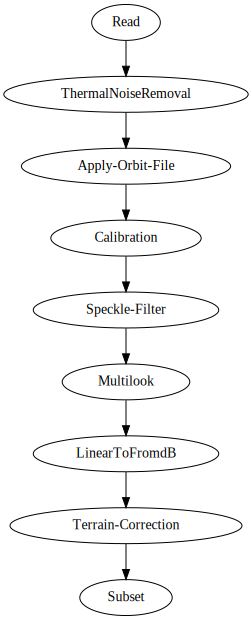

In [11]:
from graphviz import Digraph

dot = Digraph()
dot.node('A', 'Read')
dot.node('B', 'ThermalNoiseRemoval')
dot.node('C', 'Apply-Orbit-File')
dot.node('D', 'Calibration')
dot.node('E', 'Speckle-Filter')
dot.node('F', 'Multilook')
dot.node('G', 'LinearToFromdB')
dot.node('H', 'Terrain-Correction')
dot.node('I', 'Subset')


dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HI'])

dot

To ease this process, there's a Python class and few helper functions that create the XML file and run it.

Replace the default value for the parameter **file** with the path to the Sentinel-1 product

In [12]:
read = dict()
read['file'] =  s1_prd.iloc[0]['local_path']

#### ThermalNoiseRemoval

Thermal noise correction can be applied to Sentinel-1 Level-1 SLC products as well as Level-1 GRD products which have not already been corrected. The operator can also remove this correction based on the product annotations (i.e. to re-introduce the noise signal that was removed). Product annotations will be updated accordingly to allow for re-application of the correction. 

Level-1 products provide a noise LUT for each measurement data set. The values in the de-noise LUT, provided in linear power, can be used to derive calibrated noise profiles matching the calibrated GRD data.   

Bi-linear interpolation is used for any pixels that fall between points in the LUT.

#### Apply-Orbit-File

The orbit state vectors provided in the metadata of a SAR product are generally not accurate and can be refined with the precise orbit files which are available days-to-weeks after the generation of the product. 
The orbit file provides accurate satellite position and velocity information. Based on this information, the orbit state vectors in the abstract metadata of the product are updated.

For Sentinel-1, Restituted orbit files and Precise orbit files may be applied. Precise orbits are produced a few weeks after acquisition. Orbit files are automatically download from Array's servers by SNAP. If an orbit file is not found, you may try looking for it in https://qc.sentinel1.eo.esa.int/  and placing the downloaded file into the auxdata folder.

#### Calibration

The objective of SAR calibration is to provide imagery in which the pixel values can be directly related to the radar backscatter of the scene. Though uncalibrated SAR imagery is sufficient for qualitative use, calibrated SAR images are essential to quantitative use of SAR data.

Typical SAR data processing, which produces level 1 images, does not include radiometric corrections and significant radiometric bias remains. Therefore, it is necessary to apply the radiometric correction to SAR images so that the pixel values of the SAR images truly represent the radar backscatter of the reflecting surface. The radiometric correction is also necessary for the comparison of SAR images acquired with different sensors, or acquired from the same sensor but at different times, in different modes, or processed by different processors.

This Operator performs different calibrations for ASAR, ERS, ALOS and Radarsat-2 products deriving the sigma nought images. Optionally gamma nought and beta nought images can also be created.

#### Speckle-Filter

SAR images have inherent salt and pepper like texturing called speckles which degrade the quality of the image and make interpretation of features more difficult. Speckles are caused by random constructive and destructive interference of the de-phased but coherent return waves scattered by the elementary scatters within each resolution cell. Speckle noise reduction can be applied either by spatial filtering or multilook processing.

In [13]:
speckle_filter = dict()

speckle_filter['filterSizeX'] = '5'
speckle_filter['filterSizeY'] = '5'


#### Multilook

Generally, a SAR original image appears speckled with inherent speckle noise. To reduce this inherent speckled appearance, several images are incoherently combined as if they corresponded to different looks of the same scene. This processing is generally known as multilook processing. As a result the multilooked image improves the image interpretability. Additionally, multilook processing can be used to produce an application product with nominal image pixel size. 

_Multilook Method_

There are two ways to implement the multilook processing: 

* The multilooked images can be produced by space-domain averaging of a single look image, either with or without specific 2D kernels by convolution.
* The multilook images can be produced by frequency-domain method using the sub-spectral band width.
  
This operator implements the space-domain multilook method by averaging a single look image with a small sliding window. 

_Selecting Range and Azimuth Looks_

In selecting the number of range looks and the number of azimuth looks, user has two options: 

* GR square pixel: the user specifies the number of range looks while the number of azimuth looks is computed based on the ground range spacing and the azimuth spacing. The window size is then determined by the number of range looks and the number of azimuth looks. As a result, image with approximately square pixel spacing on the ground is produced.
* Independent looks: the number of looks in range and azimuth can be selected independently. The window size is then determined by the number of range looks and the number of azimuth looks.

#### LinearToFromdB

Converts bands to dB

### Terrain correction

In [14]:
terrain_correction = dict()

map_proj = """PROJCS["WGS 84 / Arctic Polar Stereographic", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Polar Stereographic (variant B)", AUTHORITY["EPSG","9829"]], 
  PARAMETER["central_meridian", 0.0], 
  PARAMETER["Standard_Parallel_1", 71.0], 
  PARAMETER["false_easting", 0.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", "South along 90 deg East"], 
  AXIS["Northing", "South along 180 deg"], 
  AUTHORITY["EPSG","3995"]]"""


terrain_correction['demName'] = 'ACE30'  
terrain_correction['saveDEM'] = 'true'
terrain_correction['mapProjection'] = map_proj
terrain_correction['nodataValueAtSea'] = 'false'   

    




### Subset 

In [15]:
def extend_aoi(center_x, center_y, extent):
    
    polar_epsg = 3575 # 3995
    latlon_epsg = 4326
    
    center_polar = loads(convert_coords(latlon_epsg, polar_epsg, Point(center_x, center_y).wkt))
    
    ll = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [16]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [17]:
from shapely.wkt import loads

poi = loads('POINT (-35.3 83.90000000000001)')

In [18]:
from shapely.geometry import Point
import osr
import ogr
from shapely import geometry

extended_aoi = extend_aoi(poi.x, poi.y, 50000)

extended_aoi

'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'

In [19]:
subset = dict() 

subset['geoRegion'] = extended_aoi 

#### Write

We will use the **GeoTIFF-BigTIFF** 

In [20]:
write = dict()
write['file'] = 'sigma0'
write['formatName'] = 'GeoTIFF-BigTiff'

#### Invoke the backscatter processing

In [24]:
backscatter(Read=read, 
            Speckle_Filter=speckle_filter,
            Terrain_Correction=terrain_correction,
            Subset=subset, 
            Write=write)

Getting default values for Operator Read
Getting default values for Operator ThermalNoiseRemoval
Getting default values for Operator Apply-Orbit-File
Getting default values for Operator Calibration
Getting default values for Operator Speckle-Filter
Getting default values for Operator Multilook
Getting default values for Operator LinearToFromdB
Getting default values for Operator Terrain-Correction
Getting default values for Operator Subset
Getting default values for Operator Write
Updating Operator Read
Updating Operator Terrain_Correction
Updating Operator Write
Updating Operator Speckle_Filter
Updating Operator Subset
Adding Operator Read to graph
Adding Operator ThermalNoiseRemoval to graph
Adding Operator Apply-Orbit-File to graph
Adding Operator Calibration to graph
Adding Operator Speckle-Filter to graph
Adding Operator Multilook to graph
Adding Operator LinearToFromdB to graph
Adding Operator Terrain-Correction to graph
Adding Operator Subset to graph
Adding Operator Write to gr

### Plot the quicklook

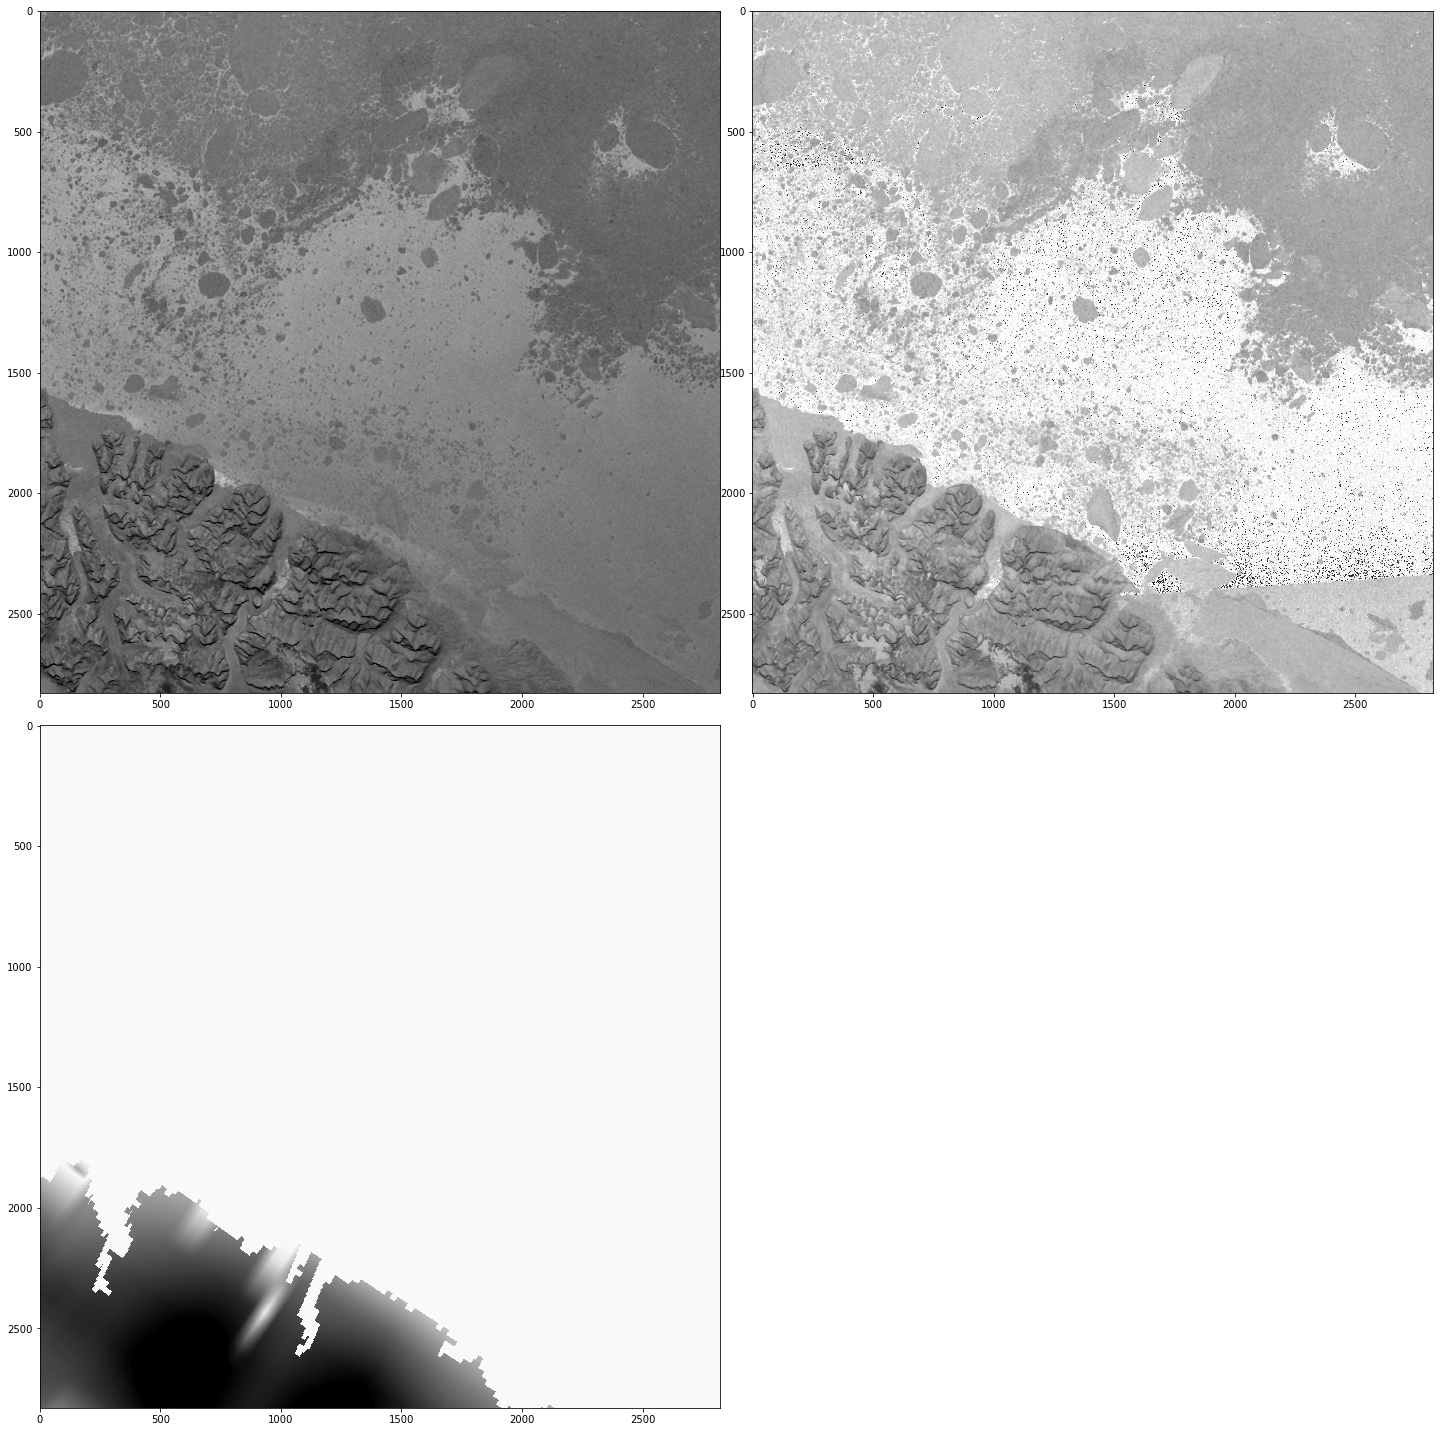

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np

fig = plt.figure(figsize=(20,20))

ds = gdal.Open('sigma0.tif')

for i in range(ds.RasterCount):
    i += 1

    band = ds.GetRasterBand(i)

    a=fig.add_subplot(2, 2, 0+i)
    
    if i == 3:
        imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=0, 
                         vmax=1000)
    else:
        imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=-36, 
                         vmax=6)

    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()



### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.